In [3]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
sns.set_style('dark')

In [10]:
# loading from parquet because it's relatively fast
train_df = pd.read_parquet("riiid-parquet/train.parquet")

In [3]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,None
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [4]:
# quickly check if there are any null values
train_df.isnull().sum()

row_id                                  0
timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64

In [ ]:
corr = train_df.corr()

In [13]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

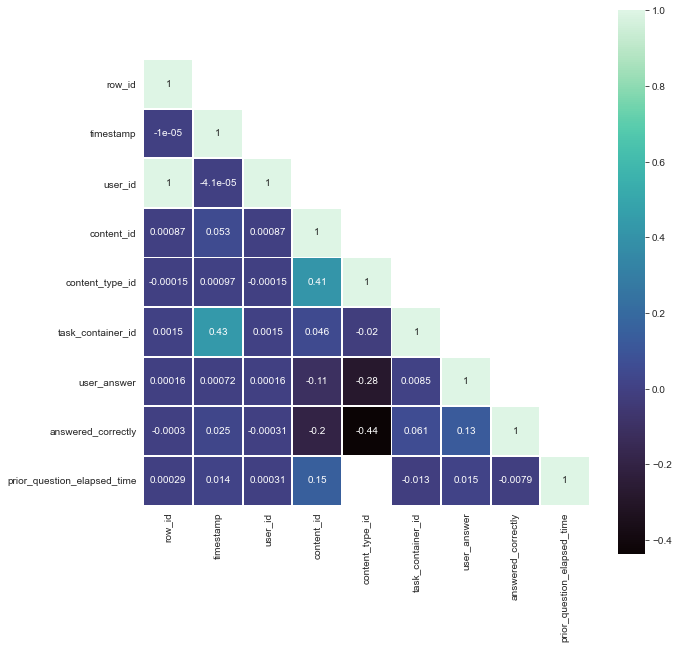

In [15]:
# plot correlation as heatmap
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corr,mask=mask,square=True,linewidths=.8,cmap="mako",annot=True)

In [4]:
questions = pd.read_parquet("riiid-parquet/questions.parquet")

In [5]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [6]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int32 
 1   bundle_id       13523 non-null  int32 
 2   correct_answer  13523 non-null  int32 
 3   part            13523 non-null  int32 
 4   tags            13523 non-null  object
dtypes: int32(4), object(1)
memory usage: 317.1+ KB


In [7]:
questions = questions.dropna()

In [9]:
# get total number of unique tags
questions['tags'] = questions['tags'].astype(str)

tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
len(tags)

188

In [11]:
# add right + wrong answer stats to questions
tags_list = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list
questions.head()

correct = train_df[train_df.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['Wrong', 'Right']
correct = correct.fillna(0)
correct[['Wrong', 'Right']] = correct[['Wrong', 'Right']].astype(int)
questions = questions.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
questions.head()

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,"[51, 131, 162, 38]",637,6266
1,1,1,1,1,"[131, 36, 81]",809,6589
2,2,2,0,1,"[131, 101, 162, 92]",20015,24890
3,3,3,0,1,"[131, 149, 162, 29]",5067,17906
4,4,4,3,1,"[131, 5, 162, 38]",12275,19461


In [12]:
# calculate percentages
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = pd.DataFrame()
    for y in range(len(questions)):
        if (tags[x] in questions.tags.values[y]):
            df = df.append(questions.iloc[y,:])

    df1 = df.agg({'Wrong': ['sum'], 'Right': ['sum']})
    df1['Total_questions'] = df1.Wrong + df1.Right
    df1['Question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['Wrong', 'Right', 'Total_questions']] = tags_df[['Wrong', 'Right', 'Total_questions']].astype(int)
tags_df['Percent_correct'] = tags_df.Right/tags_df.Total_questions
tags_df = tags_df.sort_values(by = "Percent_correct")

tags_df.head()

,Wrong,Right,Total_questions,Question_ids_with_tag,Percent_correct
tag,,,,,
24,157631,98982,256613,17,0.385725
23,261611,204293,465904,11,0.438487
19,173602,136367,309969,57,0.439938
151,272267,264913,537180,16,0.493155
167,170386,170681,341067,11,0.500432


In [15]:
tags_select.head()

tag
24     0.385725
23     0.438487
19     0.439938
151    0.493155
167    0.500432
Name: Percent_correct, dtype: float64

In [24]:
select_rows = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select = tags_df.iloc[select_rows,4]

# create custom palette so accuracy < 0.5 is red and rest is green
custom_palette = {}
for idx, q in tags_select.items():
    if q <= 0.5:
        custom_palette[idx] = 'r'
    else:
        custom_palette[idx] = 'g'

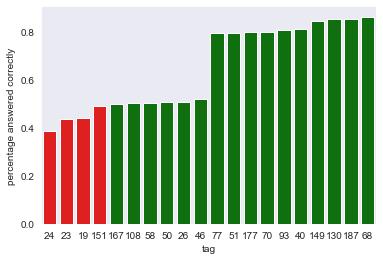

In [28]:
# plotting question tag vs percentage of correct answers
x = tags_select.index
y = tags_select.values
ax = sns.barplot(x=x, y=y, palette=custom_palette)
ax.set(ylabel='percentage answered correctly')
plt.show()

In [29]:
lectures = pd.read_parquet('riiid-parquet/lectures.parquet')

In [30]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [32]:
# get stats on the number of lectures watched
batch_lect = train_df.groupby(["task_container_id", "answered_correctly"]).size().unstack()
batch_lect.columns = ['Lecture', 'Wrong', 'Right']
batch_lect['Lecture'] = batch_lect['Lecture'].fillna(0)
batch_lect = batch_lect.astype('Int64')
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect['Percent_lecture'] = batch_lect.Lecture/(batch_lect.Lecture + batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect.sort_values(by = "Percent_lecture", ascending = False)

print(f'The highest number of lectures watched within a single task_container_id is {batch_lect.Lecture.max()}.')

The highest number of lectures watched within a single task_container_id is 5143.


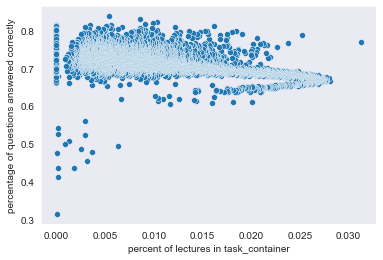

In [36]:
# plotting scatter of percent of lectures per container vs percent of questions correctly answered
batch = batch_lect.iloc[:, 3:]

x = batch.Percent_lecture
y = batch.Percent_correct
ax = sns.scatterplot(x=x, y=y)
ax.set(xlabel='percent of lectures in task_container', ylabel='percentage of questions answered correctly')

plt.show()

In [37]:
# check how many task containers have lectures
batch_lect['Has_lecture'] = np.where(batch_lect.Lecture == 0, False, True)
print(f'We have {batch_lect[batch_lect.Has_lecture == True].shape[0]} task_container_ids with lectures and {batch_lect[batch_lect.Has_lecture == False].shape[0]} task_container_ids without lectures.')

We have 9369 task_container_ids with lectures and 631 task_container_ids without lectures.


In [38]:
example_df = pd.read_csv('riiid-test-answer-prediction/example_test.csv')
example_df.head()

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN
